<a href="https://colab.research.google.com/github/johannnamr/Discrepancy-based-inference-using-QMC/blob/main/Inference/Mv-g-and-k-distribution/mvgandk_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate g-and k distribution

Notebook for the check of gradients

### Mount Drive

In [1]:
# mount my drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following path has to be adjusted if necessary:

In [2]:
%run "/content/drive/My Drive/Colab Notebooks/Utils.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/Plot_fcts.ipynb"

     |████████████████████████████████| 430 kB 13.4 MB/s 


### Imports

In [3]:
import numpy as np
import qmcpy

from copy import deepcopy

import jax.numpy as jnp
from jax import jacfwd
from jax import ops
from jax import lax

### Sampling

In [4]:
np.random.seed(111)

Set parameters:

In [5]:
m = 1500                                  # number of simulated samples
n = 1000                                  # number of true samples
theta = np.array([3,1,1,-np.log(2),0.1])  # true theta
d = 3                                     # dimensions of data
p = len(theta)                            # dimensions of parameter space
l = 1.5                                   # lengthscale (l=-1 for median heuristic)
c = 0
b = 0
nu = 0
kernel = 'gaussian'                       # 'gaussian', 'imq' or 'matern'
stat_type = 'v'                           # 'u' for U-statistic, 'v' for v-statistic

Define QMC sequence:

In [6]:
qmc = qmcpy.Halton(d+1)

Sample from the g-and-k distribution:

In [7]:
y,_ = sample_mvgandk_inv('MC',m,d,theta)
x,z = sample_mvgandk_inv('MC',n,d,theta)

Plot samples and generator:

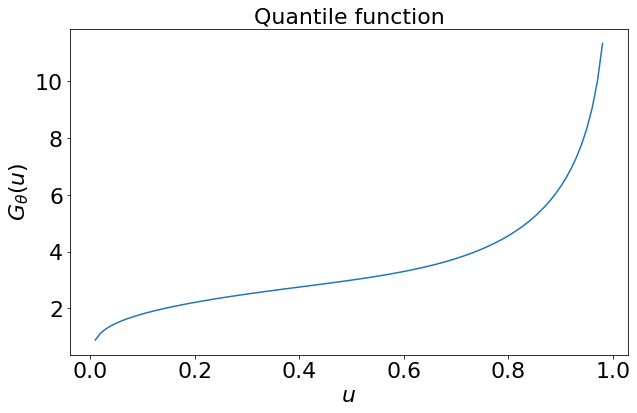

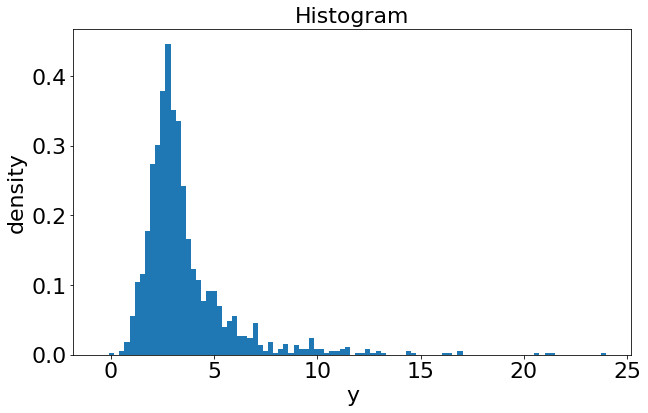

In [8]:
plot_mvgandk(y,0,(10,6),theta)

### Check generator gradient

In [9]:
print('gradient of the generator:')
grad_gen_mvgandk(z,theta)[:,:,0]

gradient of the generator:


array([[ 1.000e+00, -4.651e-01,  1.131e-01, -1.105e-01, -1.200e-02],
       [ 1.000e+00,  8.305e-03,  2.741e-05,  5.692e-07,  1.806e-01],
       [ 1.000e+00,  1.534e+00,  3.349e-01,  8.664e-01, -4.009e-02]],
      dtype=float32)

In [10]:
print('check gradient using finite differences:')
par = 1
theta_check = deepcopy(theta)
theta_check[par] = theta[par] + 0.0001
print(np.sum(grad_gen_mvgandk(z,theta)[:,par,0]))
print(np.sum((gen_mvgandk(z,theta_check)[0,:]-gen_mvgandk(z,theta)[0,:])/0.0001))

check gradient using finite differences:
1.0775405
1.0800362


### Check kernel

In [11]:
kxx = k(x,x,kernel,l,c,b,nu)
kxy = k(x,y,kernel,l,c,b,nu)
kyy = k(y,y,kernel,l,c,b,nu)
k1xx = kxx[1]
k1xy = kxy[1]
k21xx = kxx[2]

In [12]:
print('kernel:')
print(kxy[0][1,1])
print('\nderivative w.r.t. the first element:')
print(kxy[1][:,1,1])
print('\nderivative w.r.t. the second and first element:')
print(kxy[2][:,:,1,1])

kernel:
0.7925371757718426

derivative w.r.t. the first element:
[-0.334  0.114 -0.07 ]

derivative w.r.t. the second and first element:
[[ 0.211  0.048 -0.03 ]
 [ 0.048  0.336  0.01 ]
 [-0.03   0.01   0.346]]


In [13]:
#check derivatives using finite differences
print('check first derivative w.r.t. the first element:')
print((k(x+0.0001,y,kernel,l,c,b,nu)[0][1,1]-kxy[0][1,1])/0.0001)
print(np.sum(kxy[1][:,1,1]))
print('\ncheck second derivative w.r.t. the second and first element:')
print((-k(x+0.0001,y,kernel,l,c,b,nu)[1][:,1,1]+kxy[1][:,1,1])/0.0001)
print(np.sum(kxy[2][:,:,1,1],axis=0))

check first derivative w.r.t. the first element:
-0.29051012314096347
-0.28996292

check second derivative w.r.t. the second and first element:
[0.23  0.394 0.326]
[0.23  0.394 0.327]


### Check the MMD$^2$ gradient $\hat{J}$

In [14]:
print('MMD^2 approximation:')
MMD_approx(n,m,kxx[0],kxy[0],kyy[0],stat_type)

MMD^2 approximation:


-0.0003483574148863411

In [15]:
grad_g = grad_gen_mvgandk(z, theta)
print('gradient of the MMD^2 approximation:')
grad_MMD(p,n,m,grad_g,k1xx,k1xy,stat_type)

gradient of the MMD^2 approximation:


array([ 0.002, -0.004,  0.001, -0.003,  0.001], dtype=float32)

In [16]:
# check gradient using finite differences
par = 1
theta_check = deepcopy(theta)
theta_check[par] = theta_check[par] + 0.0001
x_check = gen_mvgandk(z,theta_check)
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,k(x_check,x_check,kernel,l,c,b,nu)[0],k(x_check,y,kernel,l,c,b,nu)[0],kyy[0],stat_type)-MMD_approx(n,m,kxx[0],kxy[0],kyy[0],stat_type))/0.0001)
print(grad_MMD(p,n,m,grad_g,k1xx,k1xy,stat_type)[par])

check gradient of the MMD^2 approximation:
-0.003602099441502027
-0.0036201477


### Test information metric $g_U(\theta)$

In [17]:
# test function
print('approximation of information metric g:')
g_approx(p,n,grad_g,k21xx)

approximation of information metric g:


array([[ 0.139, -0.054,  0.017, -0.045, -0.027],
       [-0.054, -0.11 , -0.023, -0.122,  0.018],
       [ 0.017, -0.023,  0.003, -0.021, -0.006],
       [-0.045, -0.122, -0.021, -0.155,  0.023],
       [-0.027,  0.018, -0.006,  0.023, -0.009]])

### Test algorithm to take the square root of  $\Sigma$:

$-0.5\leq \theta_5 \leq 0.5$

In [18]:
# loop over i
def body_fun2(i,sqrtsigma):
  # loop over j
  def body_fun1(j,sqrtsigma):
    # inner loop
    def body_fun(l,curr):
      curr = curr + jnp.sqrt(1+2*t*jnp.cos((l*jnp.pi)/(d+1)))*jnp.sin((i*l*jnp.pi)/(d+1))*jnp.sin((j*l*jnp.pi)/(d+1))
      return curr
    sqrtsigma = ops.index_update(sqrtsigma,ops.index[i-1,j-1],jnp.squeeze(lax.fori_loop(1, d+1, body_fun,jnp.array([0.]))))
    return sqrtsigma
  sqrtsigma = ops.index_update(sqrtsigma,ops.index[i-1,:],lax.fori_loop(1, d+1, body_fun1,sqrtsigma)[i-1,:])
  return sqrtsigma

In [19]:
from scipy import linalg

In [20]:
t=-0.25

In [21]:
sqrtsigma = np.eye(d)
for i in range(d-1):
  sqrtsigma[i,i+1] = t
  sqrtsigma[i+1,i] = t
sqrtsigma

array([[ 1.  , -0.25,  0.  ],
       [-0.25,  1.  , -0.25],
       [ 0.  , -0.25,  1.  ]])

In [22]:
linalg.sqrtm(sqrtsigma)

array([[ 0.992, -0.127, -0.008],
       [-0.127,  0.984, -0.127],
       [-0.008, -0.127,  0.992]])

In [23]:
lax.fori_loop(1, d+1, body_fun2, jnp.zeros([d,d]))*(2/(d+1))

DeviceArray([[ 0.992, -0.127, -0.008],
             [-0.127,  0.984, -0.127],
             [-0.008, -0.127,  0.992]], dtype=float32)

## Scatter plots

$\theta_5=0$:

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
np.random.seed(133)

In [ ]:
d = 2
m = 2**20
n = 2**6
theta1 = np.array([3,1,1,-np.log(2),0])
theta2 = np.array([3,1,1,-np.log(2),0.1])

In [ ]:
qmc = qmcpy.Halton(d,seed=7)

In [ ]:
SMALL_SIZE = 20
MEDIUM_SIZE = 32
BIGGER_SIZE = 32

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [ ]:
y_theta1,_ = sample_mvgandk_inv('QMC',m,d,theta1)
x_mc_theta1,_ = sample_mvgandk_inv('MC',n,d,theta1)
x_rqmc_theta1,_ = sample_mvgandk_inv('RQMC',n,d,theta1)
y_theta2,_ = sample_mvgandk_inv('QMC',m,d,theta2)
x_mc_theta2,_ = sample_mvgandk_inv('MC',n,d,theta2)
x_rqmc_theta2,_ = sample_mvgandk_inv('RQMC',n,d,theta2)

In [ ]:
rng_min_theta1 = np.min(y_theta1)
rng_max_theta1 = np.max(y_theta1)
num_bins_theta1 = 100
rng_min_theta2 = np.min(y_theta2)
rng_max_theta2 = np.max(y_theta2)
num_bins_theta2 = 100

In [ ]:
y1_theta1 = np.arange(rng_min_theta1, rng_max_theta1, (rng_max_theta1-rng_min_theta1)/num_bins_theta1)
y2_theta1 = np.arange(rng_min_theta1, rng_max_theta1, (rng_max_theta1-rng_min_theta1)/num_bins_theta1)
Y1_theta1, Y2_theta1 = np.meshgrid(y1_theta1, y2_theta1)
y1_theta2 = np.arange(rng_min_theta2, rng_max_theta2, (rng_max_theta2-rng_min_theta2)/num_bins_theta2)
y2_theta2 = np.arange(rng_min_theta2, rng_max_theta2, (rng_max_theta2-rng_min_theta2)/num_bins_theta2)
Y1_theta2, Y2_theta2 = np.meshgrid(y1_theta2, y2_theta2)

In [ ]:
hist_theta1,_,_ =np.histogram2d(y_theta1[:,0],y_theta1[:,1], bins=num_bins, density=True)
hist_theta2,_,_ =np.histogram2d(y_theta2[:,0],y_theta2[:,1], bins=num_bins, density=True)

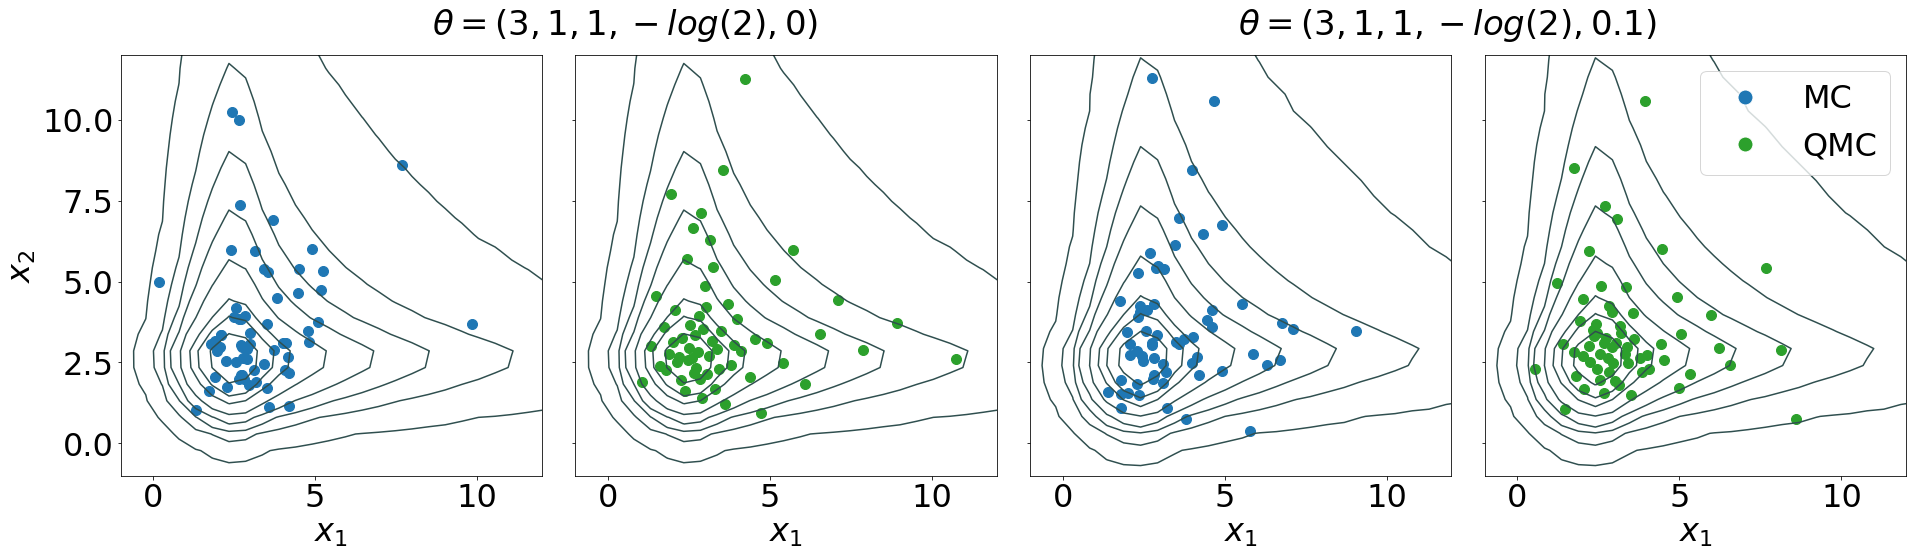

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True, sharex=True, figsize=(32,7))
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap('Greys')

ax1.contour(Y1_theta1,Y2_theta1,hist_theta1,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax1.scatter(x_mc_theta1[:,0],x_mc_theta1[:,1],color=cmap(0),s=100)
ax1.set_ylim((-1,12))
ax1.set_xlim((-1,12))
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2.contour(Y1_theta1,Y2_theta1,hist_theta1,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax2.scatter(x_rqmc_theta1[:,0],x_rqmc_theta1[:,1],color=cmap(2),s=100)
ax2.set_xlabel(r'$x_1$')

ax3.contour(Y1_theta2,Y2_theta2,hist_theta2,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax3.scatter(x_mc_theta2[:,0],x_mc_theta2[:,1],color=cmap(0),s=100)
ax3.set_xlabel(r'$x_1$')

ax4.contour(Y1_theta2,Y2_theta2,hist_theta2,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax4.scatter(x_rqmc_theta2[:,0],x_rqmc_theta2[:,1],color=cmap(2),s=100)
ax4.set_xlabel(r'$x_1$')


dots = [Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor=cmap(0), markersize=15),Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor=cmap(2), markersize=15)]
ax4.legend(handles=dots, labels=['MC','QMC'])

plt.subplots_adjust(wspace=0.08, hspace=0.05, top=0.96)
fig.text(x=0.26,y=1,s=r'$\theta=(3,1,1,-log(2),0)$',fontsize=34,fontweight=550)
fig.text(x=0.61,y=1,s=r'$\theta=(3,1,1,-log(2),0.1)$',fontsize=34,fontweight=550)

plt.savefig('mvgandk_d=2_scatter.png',bbox_inches = 'tight', pad_inches = .1)
plt.show()

$\theta_5=0.1$:

In [ ]:
np.random.seed(133)

In [ ]:
d = 2
m = 2**20
n = 2**6
theta = np.array([3,1,1,-np.log(2),0.1])

In [ ]:
qmc = qmcpy.Halton(d,seed=7)

In [ ]:
SMALL_SIZE = 28
MEDIUM_SIZE = 32
BIGGER_SIZE = 32

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [ ]:
y,_ = sample_mvgandk_inv('QMC',m,d,theta)
x_mc,_ = sample_mvgandk_inv('MC',n,d,theta)
x_rqmc,_ = sample_mvgandk_inv('RQMC',n,d,theta)

In [ ]:
rng_min = np.min(y)
rng_max = np.max(y)
num_bins = 100

In [ ]:
y1 = np.arange(rng_min, rng_max, (rng_max-rng_min)/num_bins)
y2 = np.arange(rng_min, rng_max, (rng_max-rng_min)/num_bins)

Y1, Y2 = np.meshgrid(y1, y2)

In [ ]:
hist,_,_ =np.histogram2d(y[:,0],y[:,1], bins=num_bins, density=True)

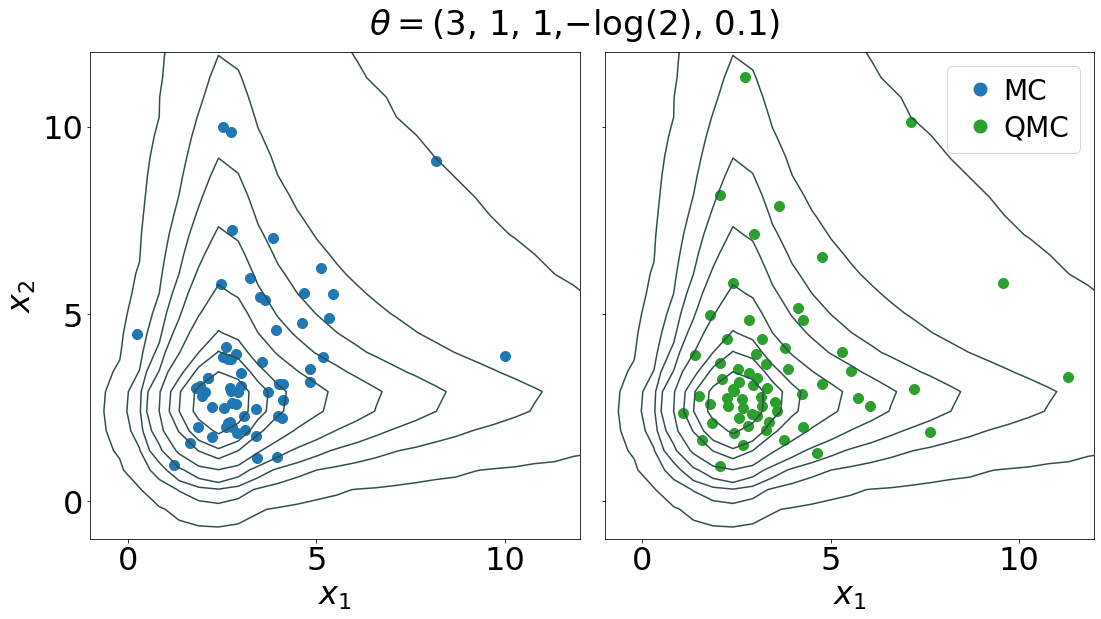

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True, sharex=True, figsize=(18,8))
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap('Greys')

ax1.contour(Y1,Y2,hist,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax1.scatter(x_mc[:,0],x_mc[:,1],color=cmap(0),s=100)
ax1.set_ylim((-1,12))
ax1.set_xlim((-1,12))
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax1.set_yticks([0,5,10])

ax2.contour(Y1,Y2,hist,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax2.scatter(x_rqmc[:,0],x_rqmc[:,1],color=cmap(2),s=100)
ax2.set_xlabel(r'$x_1$')


dots = [Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor=cmap(0), markersize=15),Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor=cmap(2), markersize=15)]
ax2.legend(handles=dots, labels=['MC','QMC'],handlelength=1.5,labelspacing=0.3,handletextpad=0.1)

plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.97)
fig.text(x=0.34,y=1,s=r'$\theta=$'+'(3, 1, 1,'+ r'$-$'+ 'log(2), 0.1)',fontsize=34,fontweight=550)

plt.savefig('mvgandk_d2_scatter.png',bbox_inches = 'tight', pad_inches = .1)
plt.show()

Number of points outside the plotted interval:

In [ ]:
np.where(x_mc>12)[0].shape

(2,)

In [ ]:
np.where(x_rqmc>12)[0].shape

(2,)